# Using an auto encoder on MNIST handwritten digits.

In [1]:
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from nn.layer import *
from nn.criterion import *
from optim.optimizer import *
from util.common import *
from dataset.transformer import *
from dataset import mnist

init_engine()

Populating the interactive namespace from numpy and matplotlib


In [5]:
mnist_path = "/home/yang/sources/datasets/mnist"
def get_minst(data_type="train"):
    # target is start from 0,
    (images, labels) = mnist.read_data_sets(mnist_path, data_type)
    mean = np.mean(images)
    std = np.std(images)
    images = sc.parallelize(images)
    record = images.map(lambda x: np.resize((x - mean)/std, (784,))).map(lambda features:
        Sample.from_ndarray(features, features))
    return record

train_data = get_minst("train")
test_data = get_minst("test")
print train_data.count()
print test_data.count()

('Extracting', '/home/yang/sources/datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


In [6]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 128
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)

In [7]:
# Create Model

def build_autoencoder(n_hidden_1, n_hidden_2, n_input):
    # Initialize a sequential container
    model = Sequential()

    # encoder
    model.add(Linear(n_input, n_hidden_1))
    model.add(Sigmoid())
    model.add(Linear(n_hidden_1, n_hidden_2))
    model.add(Sigmoid())
    # decoder
    model.add(Linear(n_hidden_2, n_hidden_1))
    model.add(Sigmoid())
    model.add(Linear(n_hidden_1, n_input))
    model.add(Sigmoid())
    return model

def build_autoencoder2(n_hidden_1, n_hidden_2, n_input):
    # Initialize a sequential container
    model = Sequential()

    # encoder
    model.add(Linear(784, 32))
    model.add(ReLU())
    model.add(Linear(32, 784))
    model.add(Sigmoid())
    
    return model
model = build_autoencoder2(n_hidden_1, n_hidden_2, n_input)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid


In [9]:
# Create an Optimizer
state = {"learningRate": 0.01, "weightDecay": 0.0, "momentum": 0.9, "dampening": 0.0}
optimizer = Optimizer(
    model=model,
    training_rdd=train_data,
    criterion=MSECriterion(),
    optim_method="Adagrad",
    state=state,
    end_trigger=MaxEpoch(2),
    batch_size=batch_size)


app_name='autoencoder-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)

optimizer.set_train_summary(train_summary)

print "saving logs to ",app_name

creating: createMSECriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createTrainSummary
saving logs to  autoencoder-20170418-140601


In [10]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 21.5 s


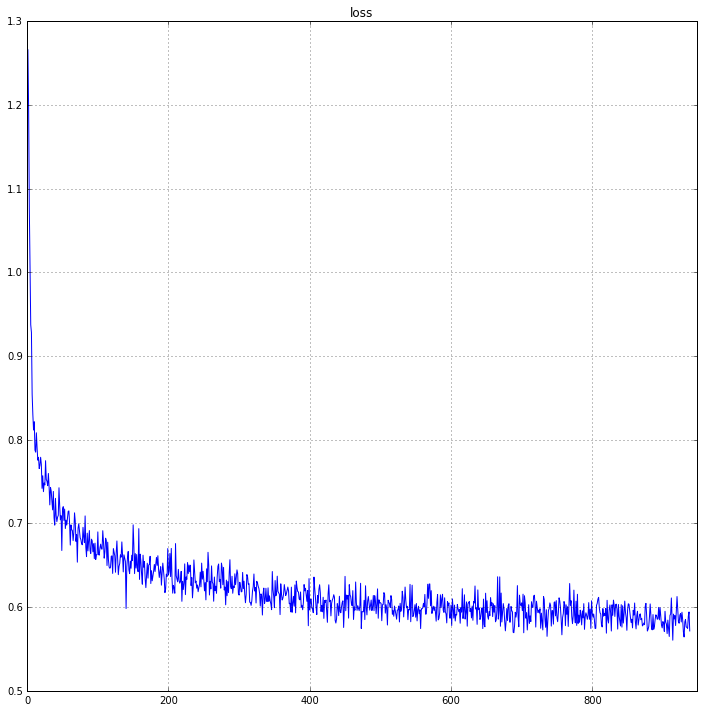

In [11]:
loss = np.array(train_summary.read_scalar("Loss"))
lr = np.array(train_summary.read_scalar("LearningRate"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")


('Extracting', '/home/yang/sources/datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-labels-idx1-ubyte.gz')


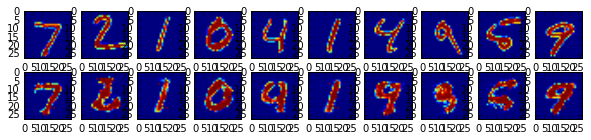

In [12]:
(images, labels) = mnist.read_data_sets(mnist_path, "test")
examples = trained_model.predict(test_data).take(10)
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(images[i], (28, 28)))
    a[1][i].imshow(np.reshape(examples[i], (28, 28)))